<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/Baseline_U_Mixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fastai.vision import *
from torchvision.models import *
from utils import *
import pandas as pd
from pathlib import Path

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD" -O CheXpert-v1.0-small.zip && rm -rf /tmp/cookies.txt

In [ ]:
!unzip -qq CheXpert-v1.0-small.zip
!rm CheXpert-v1.0-small.zip

In [ ]:
full_train_df = pd.read_csv('./CheXpert-v1.0-small/train.csv')
full_train_df = add_columns(full_train_df, False)

In [ ]:
full_valid_df = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
full_valid_df = add_columns(full_valid_df, True)

In [ ]:
# function to create class labels
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [ ]:
full_df = pd.concat([full_train_df, full_valid_df])
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [ ]:
tfms = get_transforms(do_flip=False, max_zoom=1.0, max_lighting=0.1)

In [ ]:
src = ImageList.from_df(full_df, '.', 'Path').split_from_df('train_valid').label_from_df('feature_string',label_delim=';')

In [ ]:
data = src.transform(tfms, size=320, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=59).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.densenet121, pretrained=True, metrics=avg_auc_metric)

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-02


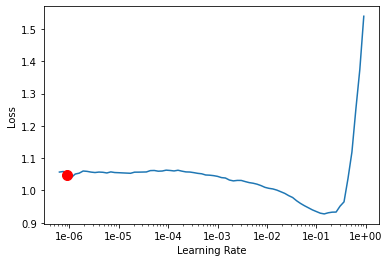

In [11]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 4e-2

In [ ]:
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='avg_auc_metric')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.414689,0.415575,0.862585,53:39
1,0.430287,0.473584,0.772696,53:56
2,0.435279,0.529756,0.877902,54:22
3,0.420236,0.410399,0.870984,52:10
4,0.397235,0.483627,0.876971,1:00:54
5,0.389341,0.438695,0.852841,52:39
6,0.380988,0.425227,0.887686,52:31
7,0.373612,0.431820,0.879605,52:10


Better model found at epoch 0 with avg_auc_metric value: 0.8625852665961569.
Better model found at epoch 2 with avg_auc_metric value: 0.877901640860522.
Better model found at epoch 6 with avg_auc_metric value: 0.8876860891929551.


In [ ]:
learn.load('Baseline U-Mixed bestmodel')

In [ ]:
validation_eval(learn, full_valid_df)

234 234
Atelectasis     	 auc: 0.829	 chexpert auc: 0.858	 difference:    0.0292
Cardiomegaly    	 auc: 0.825	 chexpert auc: 0.854	 difference:    0.0287
Consolidation   	 auc: 0.937	 chexpert auc: 0.939	 difference:    0.00243
Edema           	 auc: 0.928	 chexpert auc: 0.941	 difference:    0.0133
Pleural Effusion	 auc: 0.937	 chexpert auc: 0.936	 difference:    -0.000581

Average auc: 0.891 	 CheXpert average auc 0.906	 Difference 0.0146


In [11]:
learn.unfreeze()

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 6.31E-08


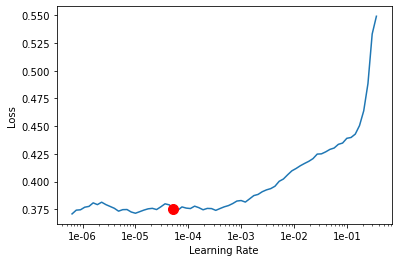

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, slice(5e-5, lr/10), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='avg_auc_metric', name='unfreeze_mixed')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.384434,0.446113,0.885019,1:00:57
1,0.391399,0.425547,0.891563,1:00:59
2,0.379727,0.460200,0.870822,59:06
3,0.381600,0.426584,0.890857,1:02:10
4,0.372015,0.427202,0.886015,1:03:31


In [ ]:
import shutil
shutil.make_archive('models', 'zip', 'models')

In [ ]:
from google.colab import files
files.download('models.zip') 

In [ ]:
learn.load('unfreeze_mixed_1')

In [22]:
learn.validate()

[0.42554712, tensor(0.8750, dtype=torch.float64)]

In [23]:
validation_eval(learn, full_valid_df)

234 234
Atelectasis     	 auc: 0.848	 chexpert auc: 0.858	 difference:    0.00957
Cardiomegaly    	 auc: 0.822	 chexpert auc: 0.854	 difference:    0.0319
Consolidation   	 auc: 0.904	 chexpert auc: 0.939	 difference:    0.0348
Edema           	 auc: 0.944	 chexpert auc: 0.941	 difference:    -0.00264
Pleural Effusion	 auc: 0.932	 chexpert auc: 0.936	 difference:    0.00413

Average auc: 0.89 	 CheXpert average auc 0.906	 Difference 0.0155
